<a href="https://colab.research.google.com/github/EmanueleGiavardi/BSP_project/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
from scipy.fftpack import fft
from sklearn.decomposition import PCA
from scipy.signal import resample
from scipy.signal import correlate, find_peaks

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [61]:
#dataset_folder (Drive) = "/content/drive/MyDrive/BSP_Project/set-a-text/"
test_sp = "/content/drive/MyDrive/BSP_Project/set-a-text/a01.csv"

def extract_stochastic_process(filename):
    df = pd.read_csv(filename, skiprows=2, header=None)

    timestamps = df[0]
    stochastic_process = []
    for i in range (1,5):
        AECG = df[i].to_numpy()
        AECG_cleaned = np.where(AECG == '-', '0', AECG)
        stochastic_process.append(AECG_cleaned.astype(float))

    return timestamps, stochastic_process

# t -> timestamp [60 seconds]
# q = 4 channels:
#   SP[0] = -> AECG1
#   SP[1] = -> AECG2
#   SP[2] = -> AECG3
#   SP[3] = -> AECG4

t, SP = extract_stochastic_process(test_sp)
sf = 1000 #sampling frequency
N = len(SP) #numero realizzazioni
colors = ['blue', 'green', 'orange', 'red'] # colori associati alle realizzazioni

In [62]:
def get_realizations_name(stochastic_process):
    names = []
    for i in range(N): names.append("AECG"+str(i+1))
    return names

realizations = get_realizations_name(SP)
realizations

['AECG1', 'AECG2', 'AECG3', 'AECG4']

In [63]:
# inversione di segno dei segnali solo perchè mi fa strano vedere i picchi QRS rivolti verso il basso
inverted_SP = []
for s in SP: inverted_SP.append(-s)

In [64]:
def plot_AECG(AECG):
    plt.figure(figsize=(14, 6))
    plt.plot(t, AECG)
    plt.title('AECG')
    plt.xlabel('Time [s]')
    plt.ylabel('Magnitude')
    plt.grid(True)
    plt.show()

def plot_fft_magnitude(signal, fs, x_limit=100, y_limit=100000):
    K = len(signal)
    f = np.linspace(0, fs / 2, K // 2)
    fft_values = fft(signal)
    magnitude = np.abs(fft_values[:K // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, magnitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.xlim(0, x_limit)
    plt.ylim(0, y_limit)
    plt.grid()
    plt.show()

def plot_fft_phase(signal, fs):
    K = len(signal)
    f = np.linspace(0, fs / 2, K // 2)
    fft_values = fft(signal)
    phase = np.angle(fft_values[:K // 2])

    plt.figure(figsize=(14, 6))
    plt.plot(f, phase)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase')
    plt.grid()
    plt.show()

def plot_stochastic_process(stochastic_process, realizations):
    fig, axes = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

    for i in range(N):
        axes[i].plot(t, stochastic_process[i], color=colors[i])
        axes[i].set_title(realizations[i])

    plt.xlabel("Time (samples)")

    plt.tight_layout()
    plt.show()

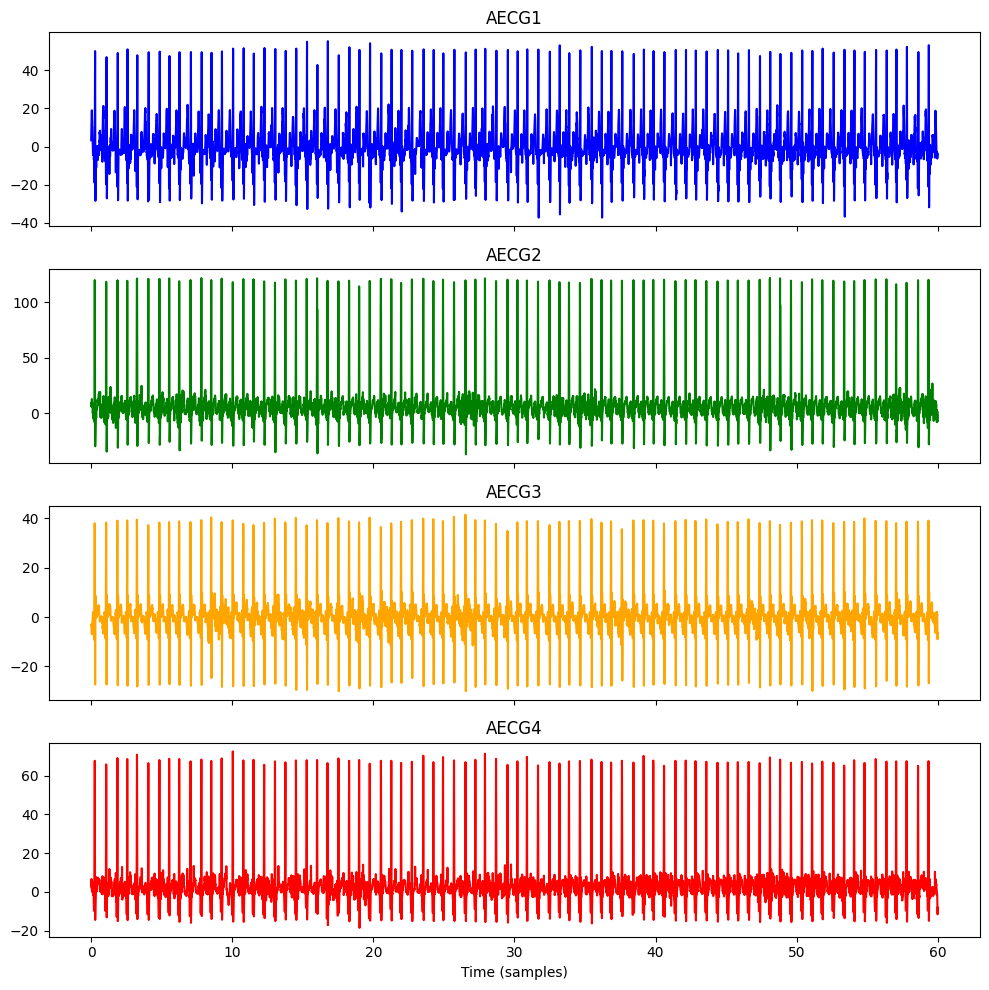

In [65]:
plot_stochastic_process(inverted_SP, realizations)

# <b>Baseline Wander Remover</b>

#### Linear Phase High-Pass Filter creation (library)

In [66]:
from scipy.signal import firwin, filtfilt

def highpass_fir_filter(signal, sf, cutoff, num_taps=1000):

    nyquist = 0.5 * sf
    cutoff_normalized = cutoff / nyquist

    # crea i coefficienti del filtro (valori del sinc finestrato di lunghezza num_taps)
    fir_coefficients = firwin(num_taps, cutoff_normalized, pass_zero=False)

    # applica la convoluzione tra i valori del sinc finestrato e il segnale
    filtered_signal = filtfilt(fir_coefficients, [1.0], signal)

    return filtered_signal, fir_coefficients


cutoff = 3
num_taps = 1000

# applicazione del filtro a tutte le realizzazioni del processo
filtered_SP = []
fir_coeffs = []
#for AECG in SP:
for AECG in inverted_SP:
    filtered_AECG, fir_coefficients =  highpass_fir_filter(AECG, sf, cutoff, num_taps+1)
    filtered_SP.append(filtered_AECG)
    fir_coeffs.append(fir_coefficients)

# TODO:
# - riguardare perchè è necessario passare taps+1
# - capire la questione dello shift temporale: perchè succede e perchè sul paper c'è scritto che è una cosa che non disturba l'analisi

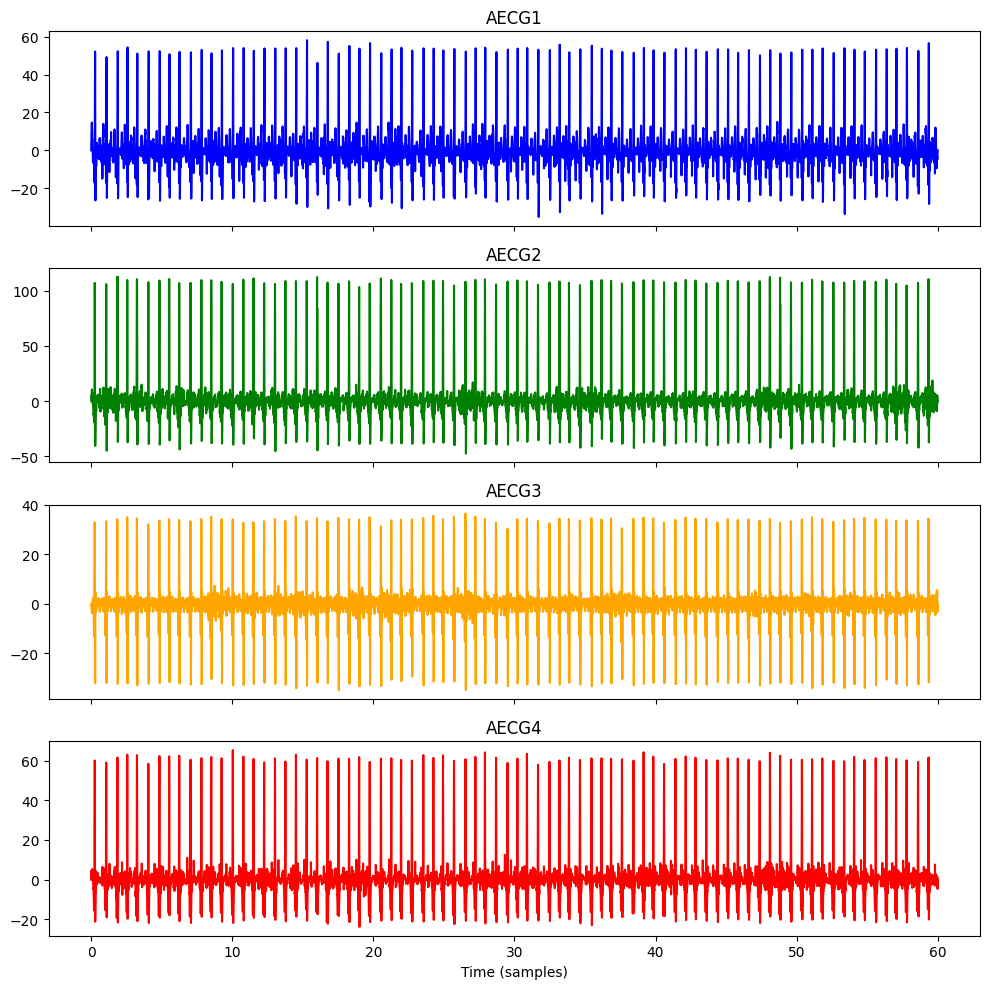

In [67]:
plot_stochastic_process(filtered_SP, realizations)

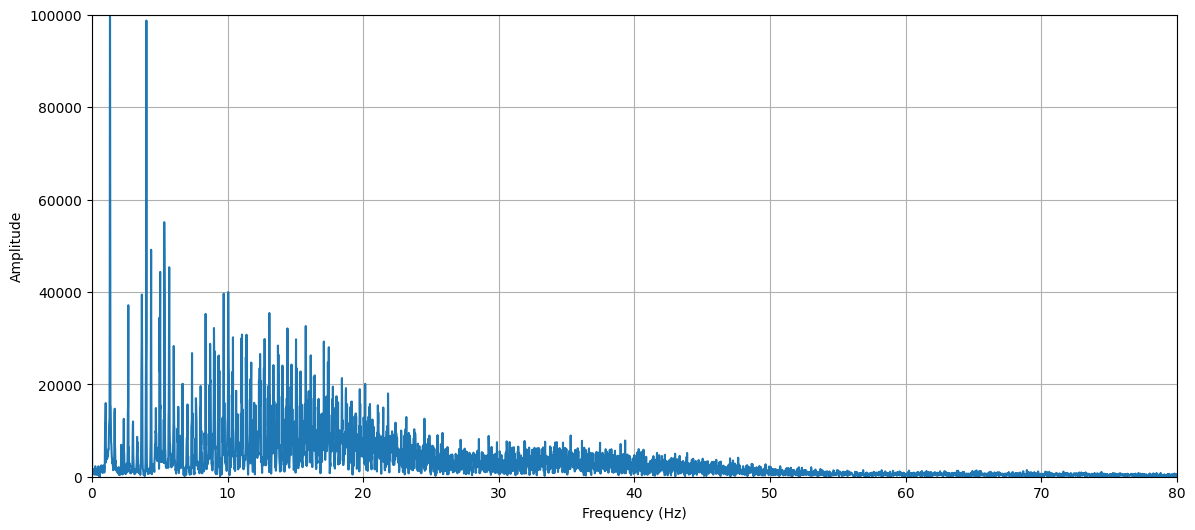

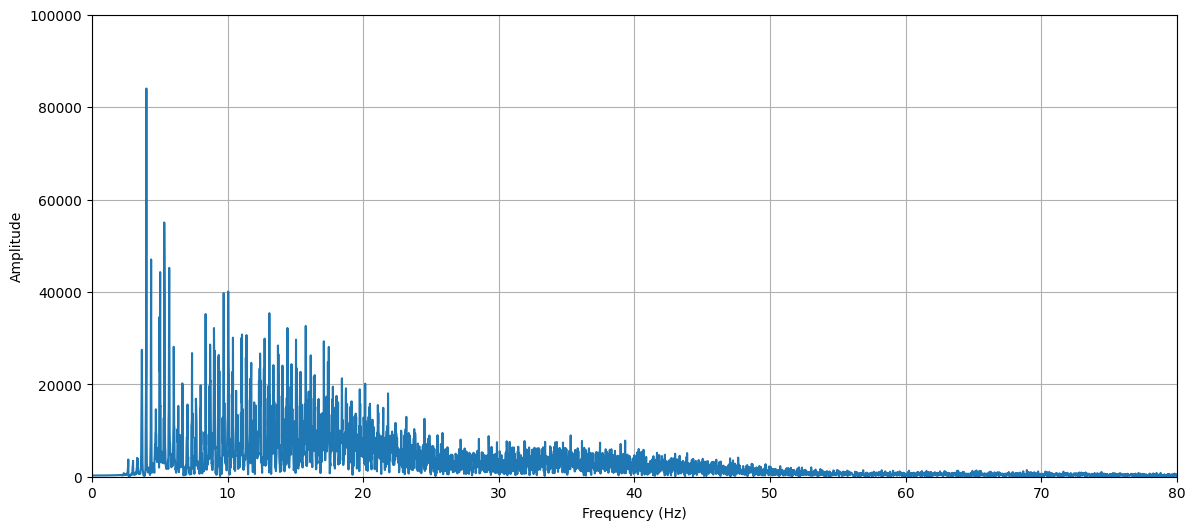

In [68]:
# Spettro del segnale originale per la prima realizzazione
plot_fft_magnitude(inverted_SP[0], sf, x_limit=80)

# Spettro del segnale filtrato per la prima realizzazione
plot_fft_magnitude(filtered_SP[0], sf, x_limit=80)

# <b>Power-line interference canceller</b>

per ora troppo complicato, inoltre sembra che gli ECG del dataset abbiano già un filtraggio notch intorno ai 50 Hz per la rimozione della PLI. TODO:
- implementare il metodo ottimizzato proposto nel paper (top)
- implementare il metodo proposto dal paper, semplificato (accettabile)
- usare un notch filter a 50 Hz (brutto)

# **Upsampling**

È sufficiente un upsampling 2X per ottenre la frequenza di campionamento utilizzata nel paper (2000 Hz)

In [69]:
def upsample_signal(signal, sf_target, sf_original, duration):
    num_samples = int(len(signal) * sf_target / sf_original)
    upsampled_signal = resample(signal, num_samples)
    upsampled_time = np.linspace(0, duration, num_samples, endpoint=False)
    return upsampled_time, upsampled_signal

upsampled_SP = []
upsampled_time = []

new_sf = 2000
duration = 60

for AECG in filtered_SP:
    ut, us = upsample_signal(AECG, new_sf, sf, duration)
    upsampled_SP.append(us)
    upsampled_time = ut

# **Maternal QRS Detector**



### **1) QRS enhancement method**

L'idea è quella di sfruttare la forte correlazione tra le componenti QRS dei vari segnali e la bassa correlazione tra il rumore che li caratterizza, assumendo che ciascuna realizzazione del processo sia caratterizzata da queste due componenti.
Passaggi:

1. Normalizzazione dei canali, dividendo ciascun canale per la sua norma (Euclidea?)
2. Applicazione della PCA sui canali
3. estrazione della prima componente come ECG con complessi QRS rafforzati

Questa procedura genera un segnale $\tilde{x}$ associato alla componente con maggiore varianza



In [70]:
# restituisce un segnale dove i complessi QRS delle varie realizzazioni sono evidenziati rispetto al rumore
def get_enhanced_QRS(stochastic_process):
    # Collocazione delle realizzazioni in una matrice X (p x q) (60000 x 4)
    X = np.column_stack([AECG for AECG in stochastic_process])
    # Normalizzazione
    norms = np.linalg.norm(X, axis=0)
    X_normalized = X / norms
    # PCA
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(X_normalized)
    enhanced_QRS = pc1.flatten()
    return enhanced_QRS, pca.explained_variance_ratio_[0]*100

enhanced_QRS, explained_variance = get_enhanced_QRS(upsampled_SP)
print(f"Varianza spiegata dalla prima componente: {round(explained_variance)}%")

Varianza spiegata dalla prima componente: 68%


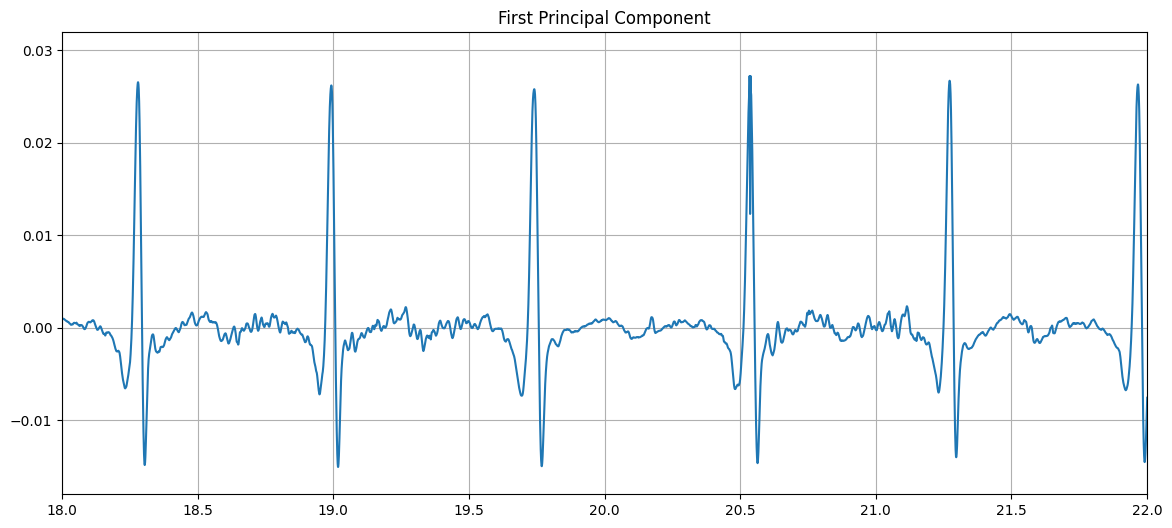

In [71]:
plt.figure(figsize=(14, 6))
plt.plot(upsampled_time, enhanced_QRS)
plt.title('First Principal Component')
plt.xlim(18, 22)
plt.grid(True)
plt.show()

### **2) QRS detection method**

L'idea qui è quella di usare un template QRS $h(t)$ e di calcolare la cross-correlazione $R_{\tilde{x},h}(τ)$ con il segnale $\tilde{x}$.

I massimi locali (picchi) di $R_{\tilde{x},h}(τ)$ saranno salvati in un vettore `R = [r1, r2, ... , rN]` che identificherà le N posizioni dei picchi QRS della madre

In [72]:
# QRS template (1 second window applied to the enhanced_QRS). Lunghezza template = 0.10 secondi (100 campioni con sf = 1000 Hz)
# si avranno quindi 50 campioni prima del picco QRS e 50 campioni dopo il picco
def create_qrs_template(signal, sf, duration_template_seconds):
    window_length = sf  # Numero di campioni in 1 secondo
    qrs_length = int(duration_template_seconds * sf)  # Numero di campioni in 0.10 secondi
    half_qrs = qrs_length // 2  # Metà della durata del QRS (0.05 secondi)

    num_windows = len(signal) // window_length
    templates = []

    for i in range(num_windows):
        # Estrazione della finestra di 1 secondo
        start_idx = i * window_length
        end_idx = start_idx + window_length
        segment = signal[start_idx:end_idx]

        # massimo assoluto nella finestra
        max_idx = np.argmax(np.abs(segment))

        # Calcola l'indice relativo al segnale originale
        global_max_idx = start_idx + max_idx

        # Estrai il template intorno al massimo assoluto
        if global_max_idx - half_qrs >= 0 and global_max_idx + half_qrs < len(signal):
            template = signal[global_max_idx - half_qrs: global_max_idx + half_qrs]
            templates.append(template)

    # Calcola il template medio (in caso di più finestre)
    if len(templates) > 0:
        final_template = np.mean(templates, axis=0)
    else:
        raise ValueError("Non è stato possibile calcolare un template.")

    return final_template


lunghezza template QRS in campioni: 200


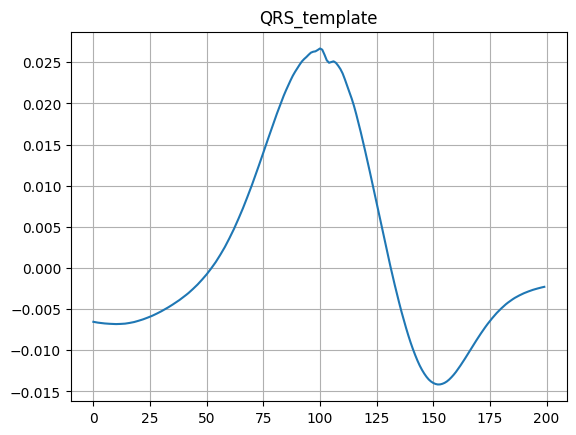

In [73]:
duration_template_seconds = 0.10

QRS_template = create_qrs_template(enhanced_QRS, new_sf, duration_template_seconds)

print(f"lunghezza template QRS in campioni: {len(QRS_template)}")
plt.plot(QRS_template)
plt.title('QRS_template')
plt.grid(True)
plt.show()

In [74]:
# CROSS CORRELATION:

def detect_qrs(signal, template, fs, threshold_factor=0.5):
    """
    Rileva i complessi QRS usando la cross-correlazione con un template.

    Parameters:
        signal (numpy array): Segnale QRS rafforzato (PCA1).
        template (numpy array): Template QRS.
        fs (int): Frequenza di campionamento (Hz).
        threshold_factor (float): Fattore per il calcolo della soglia (default: 0.5).

    Returns:
        qrs_peaks (list): Indici dei complessi QRS rilevati nel segnale.
        cross_corr (numpy array): Risultato della cross-correlazione.
    """
    # Calcolo della cross-correlazione
    cross_corr = correlate(signal, template, mode='full')
    #lags = np.arange(-len(template) + 1, len(signal))

    # Riduci la cross-correlazione alla parte positiva (lag >= 0)
    cross_corr = cross_corr[len(template)-1:]

    # normalizzazione cross_correlation
    norm_factor = (np.linalg.norm(template, axis=0))**2
    cross_corr_norm = cross_corr / norm_factor

    # Individuazione dei picchi sopra la soglia
    peaks, _ = find_peaks(cross_corr_norm, height=threshold_factor*np.max(cross_corr_norm), distance=fs//2)

    corrected_peaks = peaks + len(QRS_template) // 2

    return corrected_peaks, cross_corr_norm



1.060223238837972


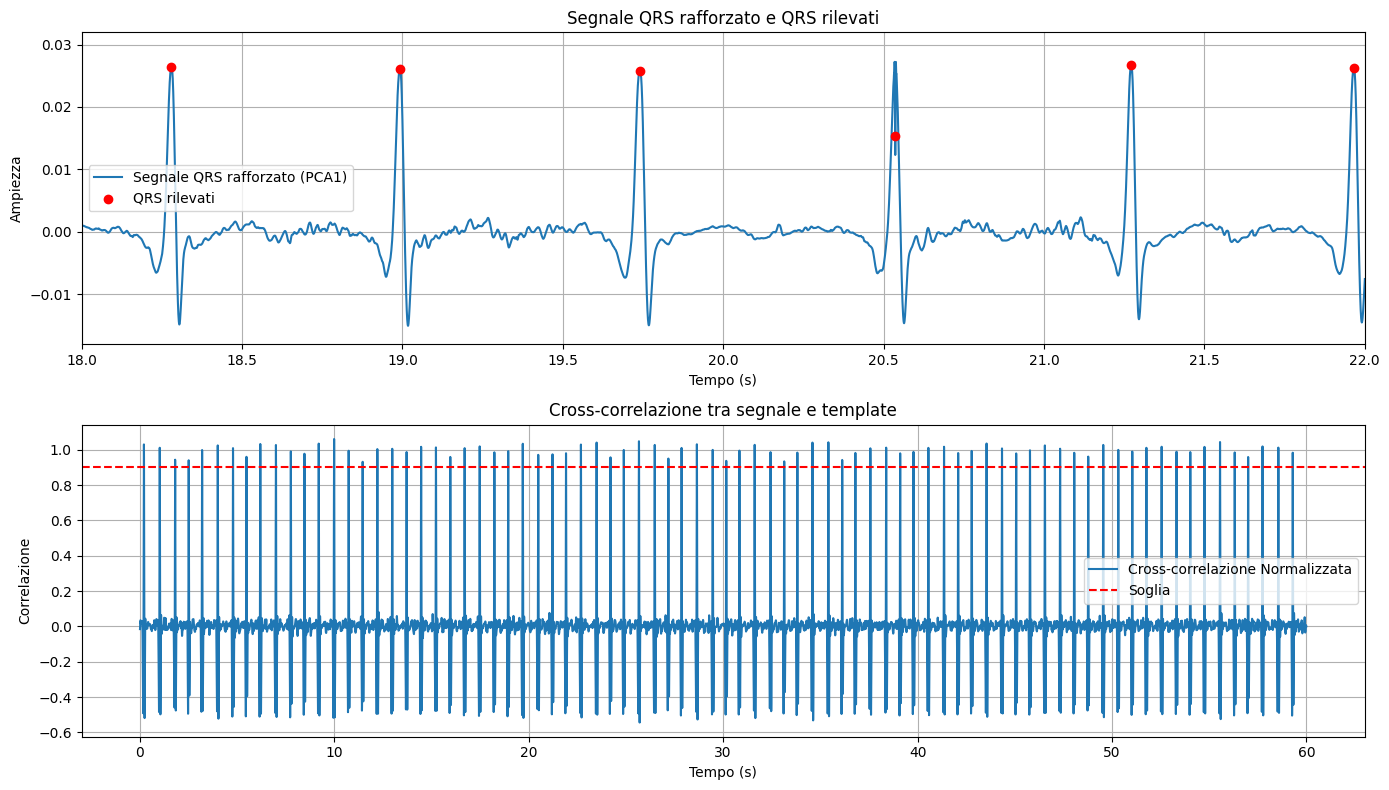

In [16]:
threshold_factor = 0.85
peaks, cross_corr = detect_qrs(enhanced_QRS, QRS_template, new_sf, threshold_factor=threshold_factor)
corr_max = np.max(cross_corr)
print(corr_max)

# Visualizzazione del risultato
plt.figure(figsize=(14, 8))

# Segnale originale con i QRS rilevati
plt.subplot(2, 1, 1)
plt.plot(upsampled_time, enhanced_QRS, label="Segnale QRS rafforzato (PCA1)")
plt.scatter(upsampled_time[peaks], enhanced_QRS[peaks], color='red', label="QRS rilevati", zorder=2)
plt.legend()
plt.title("Segnale QRS rafforzato e QRS rilevati")
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

# Cross-correlazione
plt.subplot(2, 1, 2)
plt.plot(upsampled_time[:len(cross_corr)], cross_corr, label="Cross-correlazione Normalizzata")
plt.axhline(y=threshold_factor*corr_max, color='red', linestyle='--', label="Soglia")
plt.legend()
plt.title("Cross-correlazione tra segnale e template")
plt.xlabel("Tempo (s)")
plt.ylabel("Correlazione")
plt.grid()

plt.tight_layout()
plt.show()

# **Maternal ECG Canceller**

Una porzione di MECG è definita nel seguente modo:
- *P wave:* 0.20 s
- *QRS complex:* 0.10 s
- *T wave:* 0.40 s


### **1) MECG identification**

L'MECG è identificato attraverso un metodo basato su finestratura: si costruisce una finestra centrata nel picco del complesso QRS secondo le caratteristiche sopra descritte.
La finestra avrà una durata di 1.40 s, di cui
- 0.25 prima del picco QRS
- 0.45 dopo il picco QRS

In [ ]:
P_wave_duration_seconds = 0.20
T_wave_duration_seconds = 0.40

In [75]:
def get_samples_around_QRS(wave_duration_seconds, duration_template_seconds, sf):
    return (wave_duration_seconds + duration_template_seconds/2) * sf

samples_before_QRS = get_samples_around_QRS(P_wave_duration_seconds, duration_template_seconds, new_sf)
samples_after_QRS = get_samples_around_QRS(T_wave_duration_seconds, duration_template_seconds, new_sf)

In [123]:
# salvataggio dei complessi ECG materni per ogni realizzazione in un dizionario:
# real_MECGs["AECG1"] -> [[MECG_1_1], [MECG_1_2], ..., [MECG_1_K]]
# real_MECGs["AECG2"] -> [[MECG_2_1], [MECG_2_2], ..., [MECG_2_K]]
# real_MECGs["AECG3"] -> [[MECG_3_1], [MECG_3_2], ..., [MECG_3_K]]
# real_MECGs["AECG4"] -> [[MECG_4_1], [MECG_4_2], ..., [MECG_4_K]]
#
# dove K è il numero di complessi ECG di ciascuna realizzazione (potrebbe variare da realizzazione a realizzazione)

# salvataggio delle posizioni dei complessi ECG materni per ogni realizzazione in un secondo dizionario:
# real_MECGs_positions["AECG1"] -> [(start_MECG_1_1, end__MECG_1_1), (start_MECG_1_2, end__MECG_1_2), ..., (start_MECG_1_K, end__MECG_1_K)]
# real_MECGs_positions["AECG2"] -> [(start_MECG_2_1, end__MECG_2_1), (start_MECG_2_2, end__MECG_2_2), ..., (start_MECG_2_K, end__MECG_2_K)]
# real_MECGs_positions["AECG3"] -> [(start_MECG_3_1, end__MECG_3_1), (start_MECG_3_2, end__MECG_3_2), ..., (start_MECG_3_K, end__MECG_3_K)]
# real_MECGs_positions["AECG4"] -> [(start_MECG_4_1, end__MECG_4_1), (start_MECG_4_2, end__MECG_4_2), ..., (start_MECG_4_K, end__MECG_4_K)]

def get_real_ECGs(stochastic_process, realizations, samples_before_QRS, samples_after_QRS, peaks):
    real_ECGs = {}
    real_ECGs_positions = {}

    for i in range(N):
        signal, realization = stochastic_process[i], realizations[i]
        real_ECGs[realization] = []
        real_ECGs_positions[realization] = []
        for qrs_peak in peaks:
            if (qrs_peak - samples_before_QRS > 0 and qrs_peak + samples_after_QRS < len(signal)):
                window = signal[int(qrs_peak - samples_before_QRS):int(qrs_peak + samples_after_QRS)]
                real_ECGs[realization].append(window)
                real_ECGs_positions[realization].append((int(qrs_peak - samples_before_QRS), int(qrs_peak + samples_after_QRS)))

    return real_ECGs, real_ECGs_positions

#--------------------------------------------------------------------------------------------------------------------------------------

real_MECGs, real_MECGs_positions = get_real_ECGs(upsampled_SP, realizations, samples_before_QRS, samples_after_QRS, peaks)

### **2) Average MECG**

Sia $x$ il segnale di partenza, ovvero dato dalla somma di ECG materno, ECG fetale e rumore
Viene estratto un complesso MECG medio $μ$ effettuando la media sugli N complessi MECG estratti da $x$ attraverso finestratura.

In [124]:
# salvataggio dei complessi ECG materni medi per ogni realizzazione in un dizionario:
# MECG_averages["AECG1"] -> mu_1: MECG medio della prima realizzazione
# MECG_averages["AECG2"] -> mu_2: MECG medio della seconda realizzazione
# MECG_averages["AECG3"] -> mu_3: MECG medio della terza realizzazione
# MECG_averages["AECG4"] -> mu_4: MECG medio della quarta realizzazione

def get_ECG_averages(real_ECGs):
    ECG_averages = {}

    for realization in real_ECGs:
        mu = np.mean(real_ECGs[realization], axis=0)
        ECG_averages[realization] = mu

    return ECG_averages

#--------------------------------------------------------------------------------------------------------------------------------------

MECG_averages = get_ECG_averages(real_MECGs)

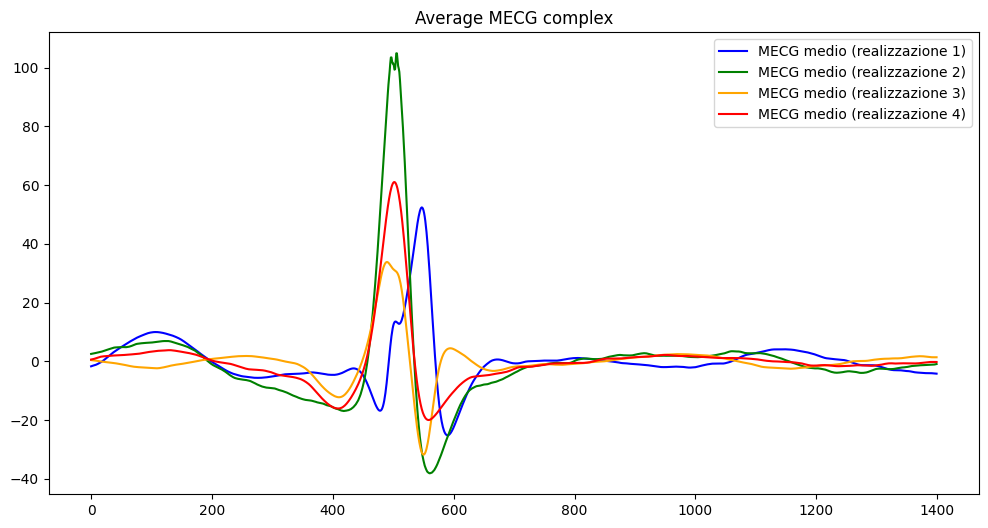

In [125]:
plt.figure(figsize=(12, 6))
for i in range(N): plt.plot(MECG_averages[realizations[i]], color=colors[i], label=f"MECG medio (realizzazione {i+1})")
plt.legend()
plt.title("Average MECG complex")
plt.show()

### **3) MECG Scaling & Subtraction using MSE minimization**

L'MECG estratto $μ$ viene risuddiviso nelle sue tre componenti:
- $\mu_{QRS} →$ contiene il complesso QRS
- $\mu_P →$ contiene l'onda P
- $\mu_T →$ contiene l'onda T

L'idea è la seguente: per ogni complesso MECG appartenente ad $x$, $\mu_{QRS}$, $\mu_P$ e $\mu_T$ vengono oppurtunamente scalati attraverso tre distinti fattori, rispettivamente $a_{QRS}$, $a_P$ e $a_T$, in modo tale che il complesso MECG medio $\mu$ matchi esattamente con il complesso MECG reale $m$.

Facendo ciò si ottiene una stima più accurata del singolo complesso MECG. Questa stima, chiamata $\hat{m}$, è definita come segue:

\begin{align*}
    \hat{m} = Ma
\end{align*}

dove $a$ è l'array contenente i tre fattori di scaling
\begin{bmatrix}
a_P\\
a_{QRS}\\
a_T
\end{bmatrix}

e $M$ è una matrice quadrata 3x3 avente le tre componenti di $\mu$ sulla diagonale:

\begin{bmatrix}
\mu_P & 0 & 0\\
0 & \mu_{QRS} & 0\\
0 & 0 & \mu_T
\end{bmatrix}

Ora, dal momento che il sample rate a questo punto della procedura è pari a 2000 Hz:
- la lunghezza di $\mu_P$ è $0.20 s \times 2000 Hz = 400$ campioni
- la lunghezza di $\mu_{QRS}$ è $0.10 s \times 2000 Hz = 200$ campioni
- la lunghezza di $\mu_T$ è $0.40 s \times 2000 Hz = 800$ campioni

Dunque $M$ in versione esplicita può essere rappresentata come:

\begin{bmatrix}
\mu_P[0] & 0 & 0\\
\mu_P[1] & 0 & 0\\
... & 0 & 0\\
\mu_P[399] & 0 & 0\\
0 & \mu_{QRS}[0] & 0\\
0 & \mu_{QRS}[1] & 0\\
0 & ... & 0\\
0 & \mu_{QRS}[199] & 0\\
0 & 0 & \mu_T[0]\\
0 & 0 & \mu_T[1]\\
0 & 0 & ...\\
0 & 0 & \mu_T[799]\\
\end{bmatrix}


Per trovare $a$, viene minimizzato l'$MSE$ tra il complesso MECG stimato $\hat{m} = Ma$ e il reale complesso MECG $m$:

\begin{align*}
    \hat{a} = argmin_{a}||Ma - m||² = argmin_{a}(ϵ²)
\end{align*}

derivando e ponendo la il risultato della derivazione uguale a 0, si ottiene:

\begin{align*}
    \hat{a} = (M^TM)^{-1}M^Tm
\end{align*}

$\hat{a}$ conterrà i valori (scalari) di scaling associati alle tre componenti del complesso, che poi verranno moltiplicati per $\mu$ (componente per componente) in modo tale da ottenere il complesso ECG materno stimato $m$

In [126]:
P_len_samples = int(P_wave_duration_seconds * new_sf)
QRS_len_samples = int(duration_template_seconds * new_sf)
T_len_samples = int(T_wave_duration_seconds * new_sf)

In [127]:
# salvataggio delle tre porzioni di mu per ogni realizzazione in un dizionario:
#                              0           1          2
# mu_portions["AECG1"] -> [ [mu_1_P], [mu_1_QRS], [mu_1_T] ]
# mu_portions["AECG2"] -> [ [mu_2_P], [mu_2_QRS], [mu_2_T] ]
# mu_portions["AECG3"] -> [ [mu_3_P], [mu_3_QRS], [mu_3_T] ]
# mu_portions["AECG4"] -> [ [mu_4_P], [mu_4_QRS], [mu_4_T] ]

def get_mu_portions(ECG_averages, P_len_samples, QRS_len_samples, T_len_samples):
    mu_portions = {}
    for realization in ECG_averages:
        mu_P = ECG_averages[realization][0:P_len_samples]
        mu_QRS = ECG_averages[realization][P_len_samples:QRS_len_samples+P_len_samples]
        mu_T = ECG_averages[realization][QRS_len_samples+P_len_samples:]
        mu_portions[realization] = [mu_P, mu_QRS, mu_T]
    return mu_portions

#--------------------------------------------------------------------------------------------------------------------------------------

mu_portions = get_mu_portions(MECG_averages, P_len_samples, QRS_len_samples, T_len_samples)

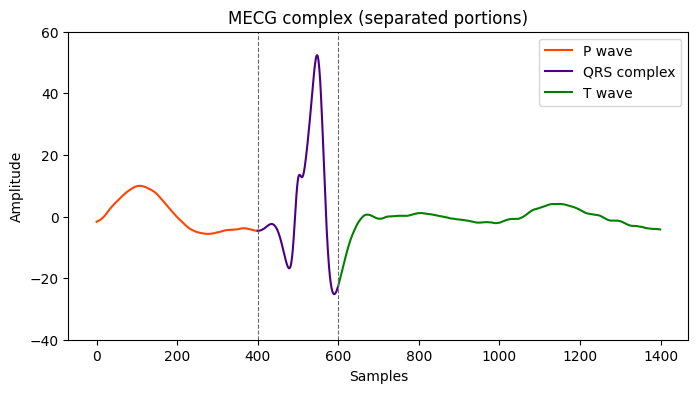

In [131]:
# plot delle porzioni di mu di una singola realizzazione, a titolo di esempio
mu = mu_portions["AECG1"]

x1 = np.arange(len(mu[0]))
x2 = np.arange(len(mu[1])) + len(mu[0])
x3 = np.arange(len(mu[2])) + len(mu[0]) + len(mu[1])

plt.figure(figsize=(8, 4))

plt.plot(x1, mu[0], label="P wave", color='orangered')
plt.plot(x2, mu[1], label="QRS complex", color='indigo')
plt.plot(x3, mu[2], label="T wave", color='green')

plt.axvline(len(mu[0]), color='dimgrey', linewidth=0.8, linestyle='--')
plt.axvline(len(mu[0]) + len(mu[1]), color='dimgrey', linewidth=0.8, linestyle='--')

plt.ylim(-40, 60)
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.title("MECG complex (separated portions)")
plt.legend()
plt.show()

In [132]:
# salvataggio delle matrici M in un dizionario:
# M_matrixes["AECG1"] -> matrice M associata ad AECG1
# M_matrixes["AECG2"] -> matrice M associata ad AECG2
# M_matrixes["AECG3"] -> matrice M associata ad AECG3
# M_matrixes["AECG4"] -> matrice M associata ad AECG4

def matrix_constructor(mu_P, mu_QRS, mu_T):
    col_1 = np.concatenate([mu_P, np.zeros(len(mu_QRS) + len(mu_T))])
    col_2 = np.concatenate([np.zeros(len(mu_P)), mu_QRS, np.zeros(len(mu_T))])
    col_3 = np.concatenate([np.zeros(len(mu_P) + len(mu_QRS)), mu_T])
    return np.column_stack([col_1, col_2, col_3])

def get_M_matrixes(mu_portions):
    M_matrixes = {}
    for realization in mu_portions: M_matrixes[realization] = matrix_constructor(mu_portions[realization][0], mu_portions[realization][1], mu_portions[realization][2])
    return M_matrixes
#--------------------------------------------------------------------------------------------------------------------------------------

M_matrixes = get_M_matrixes(mu_portions)

In [133]:
# restituisce a, un array di tre valori così definito:
# a[0] = a_P : coefficienti di scaling ottimali da applicare all'onda P
# a[1] = a_QRS : coefficienti di scaling ottimali da applicare al complesso QRS
# a[2] = a_T : coefficienti di scaling ottimali da applicare all'onda T
def get_optimized_scaled_values(M, m):
    MT = M.T
    MTM = np.dot(MT, M)
    MTM_inv = np.linalg.inv(MTM)
    MTm = np.dot(MT, m)
    return np.dot(MTM_inv, MTm)

# restituisce un array contenente le versioni di onda P, complesso QRS e onda T scalate secondo i coefficienti ottimizzati contenuti in a
def get_scaled_ECG_complex(a, mu_P, mu_QRS, mu_T):
    scaled_P = mu_P*a[0]
    scaled_QRS = mu_QRS*a[1]
    scaled_T = mu_T*a[2]
    return np.concatenate([scaled_P, scaled_QRS, scaled_T])

In [134]:
# salvataggio dei complessi ECG materni STIMATI per ogni realizzazione in un dizionario:
# estimated_MECGs_dict["AECG1"] -> [[estimated_MECG_1_1], [estimated_MECG_1_2], ..., [estimated_MECG_1_N]]
# estimated_MECGs_dict["AECG2"] -> [[estimated_MECG_2_1], [estimated_MECG_2_2], ..., [estimated_MECG_2_N]]
# estimated_MECGs_dict["AECG3"] -> [[estimated_MECG_3_1], [estimated_MECG_3_2], ..., [estimated_MECG_3_N]]
# estimated_MECGs_dict["AECG4"] -> [[estimated_MECG_4_1], [estimated_MECG_4_2], ..., [estimated_MECG_4_N]]

def get_estimated_ECGs(real_ECGs, M_matrixes, mu_portions):
    estimated_ECGs = {}
    for realization in real_ECGs:
        estimated_ECGs[realization] = []
        current_ECGs = real_ECGs[realization]
        M = M_matrixes[realization]
        K =  len(current_ECGs)
        for i in range(K):
            real_complex = current_ECGs[i]
            a = get_optimized_scaled_values(M, real_complex)
            mu_P, mu_QRS, mu_T = mu_portions[realization][0], mu_portions[realization][1], mu_portions[realization][2]
            estimated_ECGs[realization].append(get_scaled_ECG_complex(a, mu_P, mu_QRS, mu_T))

    return estimated_ECGs

#--------------------------------------------------------------------------------------------------------------------------------------

estimated_MECGs = get_estimated_ECGs(real_MECGs, M_matrixes, mu_portions)

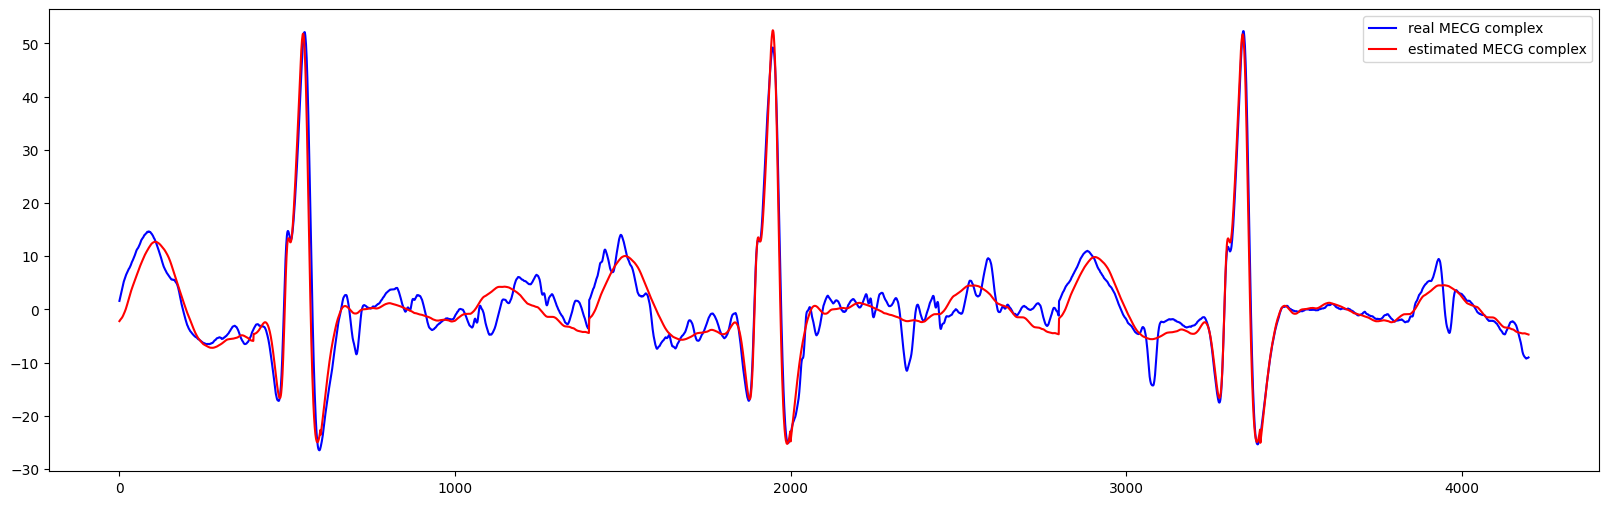

In [135]:
# plot delle prime tre componenti MECG reali e di quelle stimate per la prima realizzazione (a titolo di esempio)
first_three_reals_MECGs = np.concatenate([real_MECGs["AECG1"][0], real_MECGs["AECG1"][1], real_MECGs["AECG1"][2]])
first_three_estimated_MECGs = np.concatenate([estimated_MECGs["AECG1"][0], estimated_MECGs["AECG1"][1], estimated_MECGs["AECG1"][2]])

plt.figure(figsize=(20, 6))
plt.plot(first_three_reals_MECGs, color='blue', label="real MECG complex")
plt.plot(first_three_estimated_MECGs, color='red', label="estimated MECG complex")
plt.legend()
plt.show()

In [139]:
# reconstruct_realization parte dal segnale originale (upsampled) e sottrae gli MECG stimati solo nelle porzioni relative agli MECG reali
# il segnale risultate conterrà solo ECG fetale e altre interferenze/rumori di misurazione
def cancel_MECG(original_realization, ECG_positions, real_ECGs, estimated_ECGs):
    output = original_realization.copy()
    K = len(ECG_positions)
    for i in range(K):
        start_i_complex, end_i_complex = ECG_positions[i][0], ECG_positions[i][1]
        residual = real_ECGs[i] - estimated_ECGs[i]
        output[start_i_complex:end_i_complex] = residual
    return output

In [140]:
# processo stocastico contenente i segnali a seguito della sottrazione dell ECG materno
residual_SP = []

for i in range(N):
    realization = realizations[i]
    residual_SP.append(cancel_MECG(upsampled_SP[i], real_MECGs_positions[realization], real_MECGs[realization], estimated_MECGs[realization]))

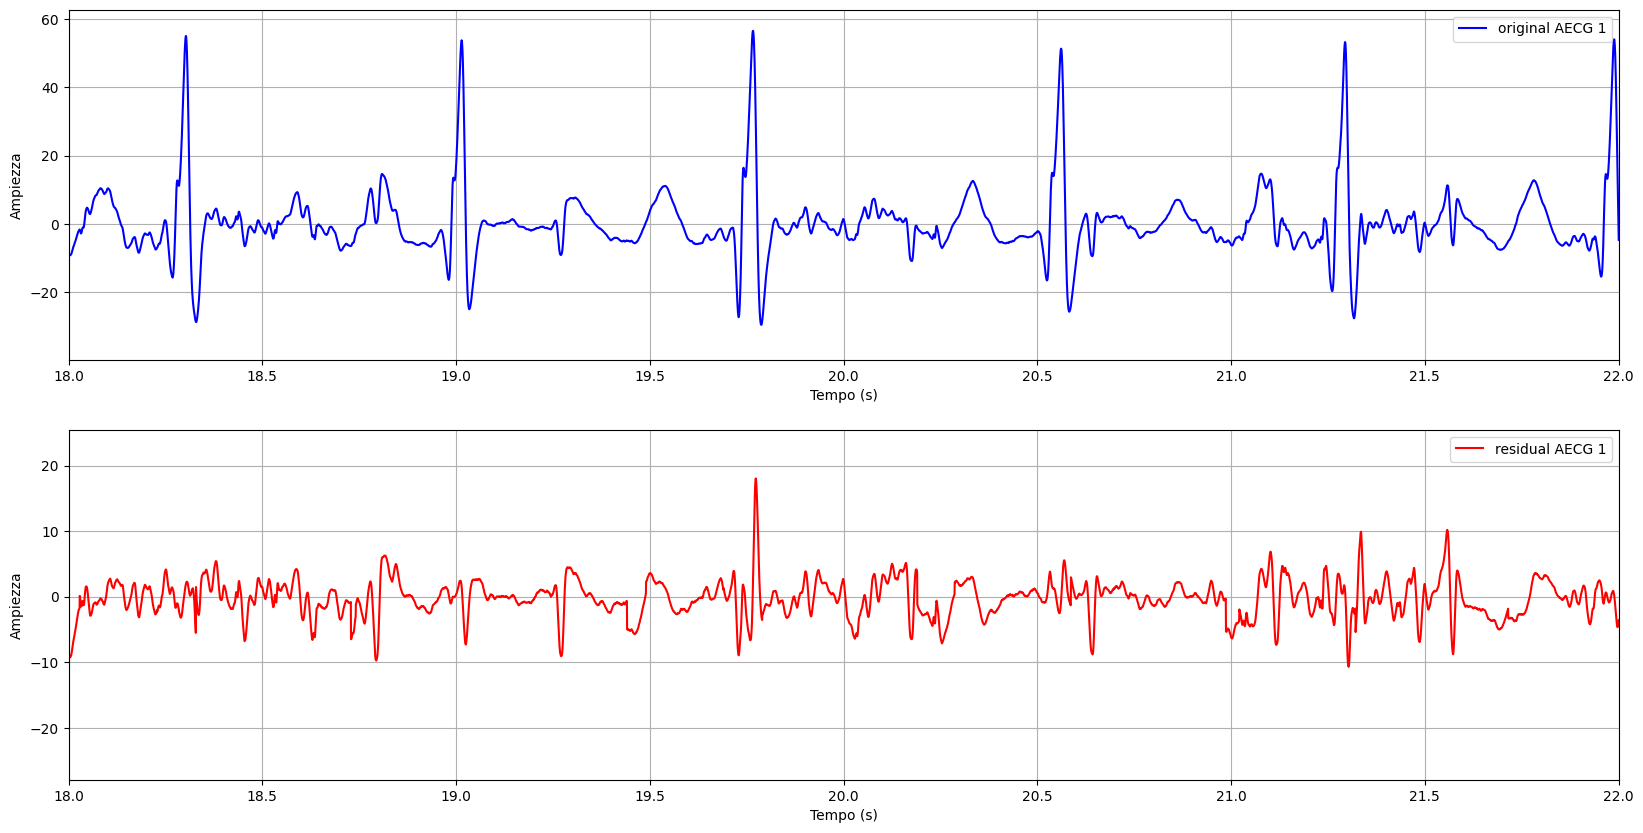

In [141]:
# plot del confronto tra la prima realizzazione originale e la prima realizzazione a seguito della sottrazione dell'ECG materno, a titolo di esempio

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
plt.plot(upsampled_time, upsampled_SP[0], color='blue', label="original AECG 1")
plt.legend()
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(upsampled_time, residual_SP[0], color='red', label="residual AECG 1")
plt.legend()
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

plt.show()

# **Fetal QRS Detector**

la procedura è la stessa usata per l'ECG materno:

processo stocastico → enhanced_QRS → QRS_template → correlazione tra QRS_template e enhanced_QRS

varianza spiegata: 44%
lunghezza template QRS fetale in campioni: 100


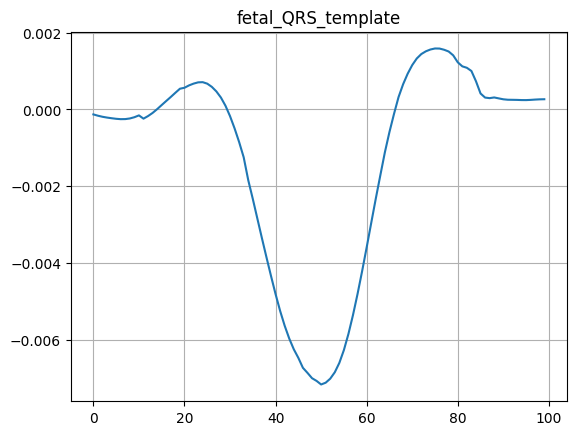

In [142]:
fetal_enhanced_QRS, fetal_explained_variance = get_enhanced_QRS(residual_SP)
print(f"varianza spiegata: {round(fetal_explained_variance)}%")

fetal_duration_template_seconds = 0.05

fetal_QRS_template = create_qrs_template(fetal_enhanced_QRS, new_sf, fetal_duration_template_seconds)

print(f"lunghezza template QRS fetale in campioni: {len(fetal_QRS_template)}")
plt.plot(fetal_QRS_template)
plt.title('fetal_QRS_template')
plt.grid(True)
plt.show()

4.742137476669247


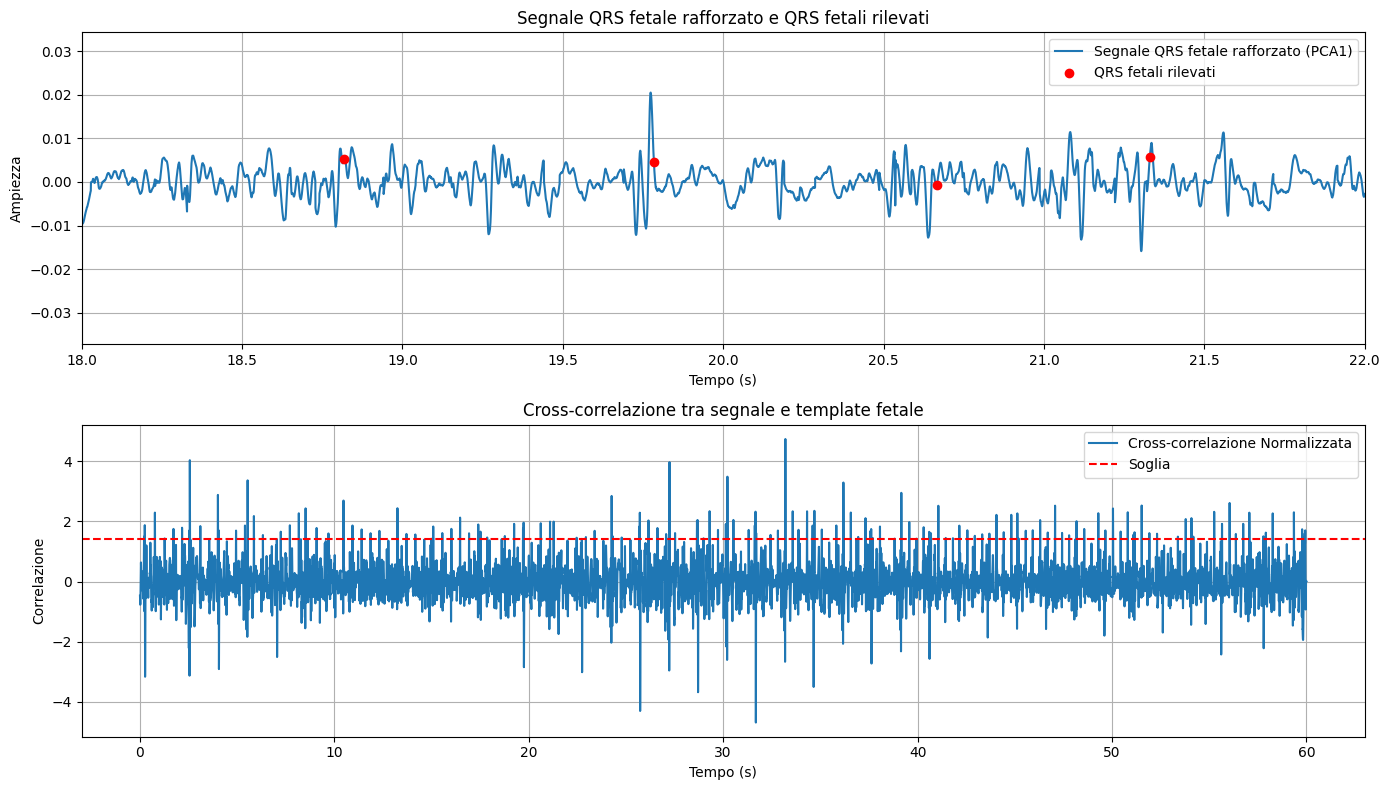

In [143]:
threshold_factor = 0.30
fetal_peaks, fetal_cross_corr = detect_qrs(fetal_enhanced_QRS, fetal_QRS_template, new_sf, threshold_factor=threshold_factor)
fetal_corr_max = np.max(fetal_cross_corr)
print(fetal_corr_max)

# Visualizzazione del risultato
plt.figure(figsize=(14, 8))

# Segnale originale con i QRS rilevati
plt.subplot(2, 1, 1)
plt.plot(upsampled_time, fetal_enhanced_QRS, label="Segnale QRS fetale rafforzato (PCA1)")
plt.scatter(upsampled_time[fetal_peaks], fetal_enhanced_QRS[fetal_peaks], color='red', label="QRS fetali rilevati", zorder=2)
plt.legend()
plt.title("Segnale QRS fetale rafforzato e QRS fetali rilevati")
plt.xlabel("Tempo (s)")
plt.xlim(18, 22)
plt.ylabel("Ampiezza")
plt.grid()

# Cross-correlazione
plt.subplot(2, 1, 2)
plt.plot(upsampled_time[:len(fetal_cross_corr)], fetal_cross_corr, label="Cross-correlazione Normalizzata")
plt.axhline(y=threshold_factor*fetal_corr_max, color='red', linestyle='--', label="Soglia")
plt.legend()
plt.title("Cross-correlazione tra segnale e template fetale")
plt.xlabel("Tempo (s)")
plt.ylabel("Correlazione")
plt.grid()

plt.tight_layout()
plt.show()